# Analsis de Datos COVID-19 en Guatemala 2020

## Codigo Python

### Carga de datos

In [17]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import os

load_dotenv()

class SQLServerConnection:
    def __init__(self):
        self.server = os.getenv("SQL_SERVER_SERVER")
        self.database = os.getenv("SQL_SERVER_DATABASE")
        self.username = os.getenv("SQL_SERVER_USERNAME")
        self.password = os.getenv("SQL_SERVER_PASSWORD")
        self.port = os.getenv("SQL_SERVER_PORT")

    # f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    def get_connection(self):
        try:          
                    
            trusted_connection = 'yes'  # Utiliza 'yes' para Windows Authentication
            driver = '{SQL Server}'                   
            # Cadena de conexión para Windows Authentication
            # Especificar el controlador de pyodbc en la cadena de conexión
            connection_string = f'mssql+pyodbc://{self.server}/{self.database}?trusted_connection={trusted_connection}&driver=ODBC+Driver+17+for+SQL+Server'

            # connection_string = f'DRIVER={driver};SERVER={self.server};DATABASE={self.database};Trusted_Connection={trusted_connection}'
            engine = create_engine(connection_string)
            return engine
        except Exception as e:
            print(f"Error de conexión: {str(e)}")
            return None
         

#### Query's and dataframes

In [18]:
# Create connection
sql_server_connection = SQLServerConnection()
connection = sql_server_connection.get_connection()

print("connection: ", connection)

# Consulta SQL para extraer datos
sql_query_municipality =  """
SELECT M.code_municipality, M.municipality, M.population,
	   D.code_department, D.name_department,
	   C.code_country, C.name_country
FROM Municipality AS M
JOIN Department AS D ON M.code_department = D.code_department
JOIN Country AS C ON D.code_country = C.code_country;
"""
sql_query_department = 'SELECT * FROM Department'
sql_query_country_cases = 'SELECT * FROM Cases'
sql_query_mdp = """
SELECT
    M.municipality,
    MDR.code_municipality,
    MDR.date_reported,
    MDR.new_deaths,
    SUM(MDR.new_deaths) OVER (PARTITION BY MDR.code_municipality ORDER BY MDR.date_reported) AS cumulative_deaths
FROM
    MunicipalityDeathsReported MDR
JOIN
    Municipality M
        ON M.code_municipality = MDR.code_municipality
ORDER BY
    MDR.code_municipality, MDR.date_reported;
"""
sql_query_mdp_gt_0 = """
SELECT
    M.municipality,
    D.name_department,
    MDR.code_municipality,
    MDR.date_reported,
    MDR.new_deaths,
    SUM(MDR.new_deaths) OVER (PARTITION BY MDR.code_municipality ORDER BY MDR.date_reported) AS cumulative_deaths
FROM
    MunicipalityDeathsReported MDR
JOIN
    Municipality M
        ON M.code_municipality = MDR.code_municipality
JOIN
    Department D
        ON M.code_department = D.code_department
WHERE
    MDR.new_deaths > 0
ORDER BY
    MDR.code_municipality, MDR.date_reported;
"""

# Ejecutar la consulta y cargar los resultados en DataFrames
df_municipality = pd.read_sql(sql_query_municipality, connection)
df_department = pd.read_sql(sql_query_department, connection)
df_country_cases = pd.read_sql(sql_query_country_cases, connection)
df_mdp = pd.read_sql(sql_query_mdp, connection)
df_mdp_gt_0 = pd.read_sql(sql_query_mdp_gt_0, connection)

df_municipality = df_municipality.drop_duplicates()
df_department = df_department.drop_duplicates()
df_country_cases = df_country_cases.drop_duplicates()
df_mdp = df_mdp.drop_duplicates()
df_mdp_gt_0 = df_mdp_gt_0.drop_duplicates()

connection:  Engine(mssql+pyodbc://DESKTOP-4JJFHV8\SQLEXPRESS/ss2?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes)


In [19]:
df_mdp_gt_0.head()

,municipality,name_department,code_municipality,date_reported,new_deaths,cumulative_deaths
0,MAZATENANGO,SUCHITEPEQUEZ,1001,2020-05-16,1,1
1,MAZATENANGO,SUCHITEPEQUEZ,1001,2020-05-19,1,2
2,MAZATENANGO,SUCHITEPEQUEZ,1001,2020-06-28,1,3
3,MAZATENANGO,SUCHITEPEQUEZ,1001,2020-07-02,1,4
4,MAZATENANGO,SUCHITEPEQUEZ,1001,2020-07-03,1,5


### Funciones para análisis de datos

#### Funciones histogramas log, de caja, histogramas estándares y análisis estadísticos

In [20]:
def plot_analysis(df, variable_name):
    # Filtra los valores mayores que cero
    filtered_data = df[variable_name][df[variable_name] > 0]

    # Configurar el estilo de seaborn
    sns.set(style="whitegrid")

    # Crear una figura con subgráficos
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Histograma con la transformación logarítmica
    sns.histplot(filtered_data, bins=20, kde=True, edgecolor='black', log_scale=True, ax=axes[0])
    axes[0].set_xlabel(f'Logaritmo de {variable_name}')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_title(f'Histograma logarítmico de {variable_name}')

    # Diagrama de caja
    sns.boxplot(y=filtered_data, ax=axes[1])
    axes[1].set_ylabel(variable_name)
    axes[1].set_title(f'Diagrama de caja de {variable_name}')

    # Histograma estándar
    sns.histplot(filtered_data, bins=20, kde=True, edgecolor='black', ax=axes[2])
    axes[2].set_xlabel(variable_name)
    axes[2].set_ylabel('Frecuencia')
    axes[2].set_title(f'Histograma estándar de {variable_name}')

    # Estadísticas descriptivas
    statistics = filtered_data.describe()
    statistics_translated = statistics.rename(index={
        'count': 'Conteo',
        'mean': 'Promedio',
        'std': 'Desviación Estándar',
        'min': 'Mínimo',
        '25%': 'Cuartil 25%',
        '50%': 'Mediana',
        '75%': 'Cuartil 75%',
        'max': 'Máximo'
    })

    # Añadir estadísticas traducidas a la tabla
    axes[3].axis('off')
    axes[3].table(cellText=statistics_translated.reset_index().values,
                  colLabels=['Estadísticas', 'Valor'],
                  cellLoc='center', loc='center', colColours=['#f2f2f2']*2)
    axes[3].set_title(f'Estadísticas descriptivas de {variable_name}')

    # Ajustar el diseño
    plt.tight_layout()
    plt.show()

def descr(df, variable_name):
    # Filtra los valores mayores que cero
    filtered_data = df[variable_name][df[variable_name] > 0]

    # Estadísticas descriptivas
    statistics = filtered_data.describe()
    statistics_translated = statistics.rename(index={
        'count': 'Conteo',
        'mean': 'Promedio',
        'std': 'Desviación Estándar',
        'min': 'Mínimo',
        '25%': 'Cuartil 25%',
        '50%': 'Mediana',
        '75%': 'Cuartil 75%',
        'max': 'Máximo'
    })
    print(f'Estadisticas monovariables de {variable_name}')
    print(statistics_translated, '\n')

#### Funcion datos cualitativos

In [21]:
def generate_count_plot(data, x_column, x_label, y_label, title, size=False):
    """
    Genera un diagrama de barras para el conteo de registros.

    Parameters:
    - data: DataFrame que contiene los datos.
    - x_column: Nombre de la columna en el DataFrame para el eje x.
    - x_label: Etiqueta del eje x.
    - y_label: Etiqueta del eje y.
    - title: Título del diagrama.
    - size: Booleano que indica si se usará un tamaño personalizado para la figura.

    Returns:
    None (muestra el diagrama y una tabla).
    """
    # Configurar el estilo de seaborn
    sns.set(style="whitegrid")

    # Crear un diagrama de barras
    figsize = (50, 6) if size else (15, 6)
    plt.figure(figsize=figsize)
    sns.countplot(data=data, x=x_column, order=data[x_column].value_counts().index)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')

    # Mostrar la cantidad total de datos
    total_data = len(data)
    # print(f"Cantidad total de datos de {title}: {total_data}")

    # Mostrar una tabla con los resultados del histograma
    histogram_table = pd.DataFrame(data[x_column].value_counts()).reset_index()
    histogram_table.columns = [x_column, 'Count']
    # print(histogram_table)

    plt.show()


def generate_sum_plot(data, x_column, y_column, x_label, y_label, title, size=False):
    """
    Genera un diagrama de barras para el conteo de registros.

    Parameters:
    - data: DataFrame que contiene los datos.
    - x_column: Nombre de la columna en el DataFrame para el eje x.
    - x_label: Etiqueta del eje x.
    - y_label: Etiqueta del eje y.
    - title: Título del diagrama.
    - size: Booleano que indica si se usará un tamaño personalizado para la figura.
    - is_count: Booleano que indica si se realizará un conteo (True) o una suma (False).

    Returns:
    None (muestra el diagrama y una tabla).
    """
    # Configurar el estilo de seaborn
    sns.set(style="whitegrid")

    # Crear un diagrama de barras
    figsize = (50, 6) if size else (15, 6)
    plt.figure(figsize=figsize)

    # Filtrar datos
    data_filtered = data[data[x_column] != 0]

    # Realizar una sumatoria de todos los valores en el DataFrame filtrado
    df_count = data_filtered.groupby(y_column).agg({x_column: 'sum'}).reset_index()
    df_count.columns = [x_column, 'Count']

    # Filtrar valores con al menos min_occurrences ocurrencias
    min_occurrences = 1  # Puedes ajustar este valor según tus necesidades
    values_to_plot = df_count[df_count['Count'] >= min_occurrences][x_column]

    # Usar values_to_plot para imprimir el histograma
    # print(values_to_plot)

    # Graficar el histograma
    sns.barplot(data=df_count, x=x_column, y='Count')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')

    # Mostrar la cantidad total de datos
    total_data = len(data)
    # print(f"Cantidad total de datos de {title}: {total_data}")
    # print(df_count)
    plt.show()



#### Funcion para generar diagramas multivariables

In [22]:

def generate_multivariable_plots(data, x_column, y_column, values_column, x_label, y_label, title, rotation=0, size=False):
    """
    Genera un diagrama de barras y un mapa de calor para variables multivariables.

    Parameters:
    - data: DataFrame que contiene los datos.
    - x_column: Nombre de la columna en el DataFrame para el eje x.
    - y_column: Nombre de la columna en el DataFrame para el eje y.
    - values_column: Nombre de la columna con los valores a mostrar en el mapa de calor.
    - x_label: Etiqueta del eje x.
    - y_label: Etiqueta del eje y.
    - title: Título de los gráficos.
    - rotation: Ángulo de rotación de las etiquetas en el eje x (por defecto, 0).
    - size: Tamaño de los gráficos (por defecto, False).

    Returns:
    None (muestra el diagrama de barras y el mapa de calor).
    """
    sns.set(style="whitegrid")

    # Diagrama de Barras
    figsize = (100, 6) if not size else (6, 50)
    plt.figure(figsize=figsize)
    sns.barplot(data=data, x=x_column, y=y_column)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title + " - Diagrama de Barras")
    plt.xticks(rotation=rotation)  # Eliminamos el parámetro ha='right'
    plt.show()

def generate_heatmaps(df, x_column, y_column, x_label, y_label, title, min_occurrences=10, num_row_per_graph=10, num_plots_per_row=4, is_count=True):
    # Filtrar datos
    df_filtered = df[df[x_column] != 0]

    # Realizar el cálculo según el valor de is_count
    if is_count:
        # Contar las ocurrencias de cada valor en la columna y en el DataFrame filtrado
        df_count = df_filtered.groupby(y_column).size().reset_index(name='count')
    else:
        # Realizar una sumatoria de todos los valores en el DataFrame filtrado
        df_count = df_filtered.groupby(y_column).agg({x_column: 'sum'}).reset_index()
        df_count.columns = [y_column, 'count']

    # Filtrar valores con al menos min_occurrences ocurrencias
    values_to_plot = df_count[df_count['count'] >= min_occurrences][y_column]

    # Dividir los valores en grupos de num_plots_per_row
    values_groups = np.array_split(values_to_plot, len(values_to_plot) // num_row_per_graph + 1)

    # Configurar el estilo de seaborn
    sns.set(style="whitegrid")

    # Calcular el número necesario de filas
    num_rows = max(1, len(values_groups) // num_plots_per_row + (1 if len(values_groups) % num_plots_per_row else 0))

    # Calcular el valor máximo global para 'count' entre los valores filtrados
    global_max_count = df_count[df_count[y_column].isin(values_to_plot)]['count'].max()

    # Crear subgráficas
    fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, 1 * num_row_per_graph))

    for i, values_group in enumerate(values_groups):
        # Filtrar el DataFrame original para el grupo actual
        df_group = df_filtered[df_filtered[y_column].isin(values_group)]

        # Contar las ocurrencias de cada valor en el DataFrame filtrado
        df_group_count = df_group.groupby(y_column).agg({x_column: 'sum'}).reset_index()
        df_group_count.columns = [y_column, 'count']

        # Crear un mapa de calor para el grupo actual
        ax = axes[i] if len(values_groups) == 1 else axes[i // num_plots_per_row, i % num_plots_per_row]
        sns.heatmap(df_group_count.pivot_table(index=y_column, values='count', aggfunc='sum'),
                    cmap=sns.color_palette("Spectral", as_cmap=True), annot=True, fmt='g', ax=ax,
                    vmin=0, vmax=global_max_count)  # Usar global_max_count en lugar de df_group_count['count'].max()

        # Añadir título
        ax.set_title(f'{y_label} Grupo {i + 1}')

    # Ajustar el diseño
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
# generate_multivariable_plots(df, 'municipality', 'new_deaths', 'cumulative_deaths', 'Municipio', 'Cantidad', 'Análisis Multivariable de Nuevas Muertes')

## EDA Monovariable

### Datos cuantitativos

#### Graficos monovariables cuantitativos

**Análisis de la variable `population`**
| **Histograma logarítmico de `population`** | **Diagrama de caja de `population`** | **Histograma estándar de `population`** |
| ------------------ | ------------------ | ------------- |
| El histograma logarítmico muestra la distribución de las poblaciones de los municipios. La transformación logarítmica se aplicó para mejorar la visualización eliminando ceros y ajustando escalas. | El diagrama de caja presenta la variabilidad y distribución de las poblaciones de los municipios. Se observa una amplia gama de tamaños de población, con algunos municipios que tienen valores atípicos significativamente más altos. | El histograma estándar muestra la distribución de las poblaciones de los municipios sin la transformación logarítmica. La mayoría de los municipios tienen poblaciones moderadas, mientras que algunos tienen tamaños de población excepcionalmente altos. |

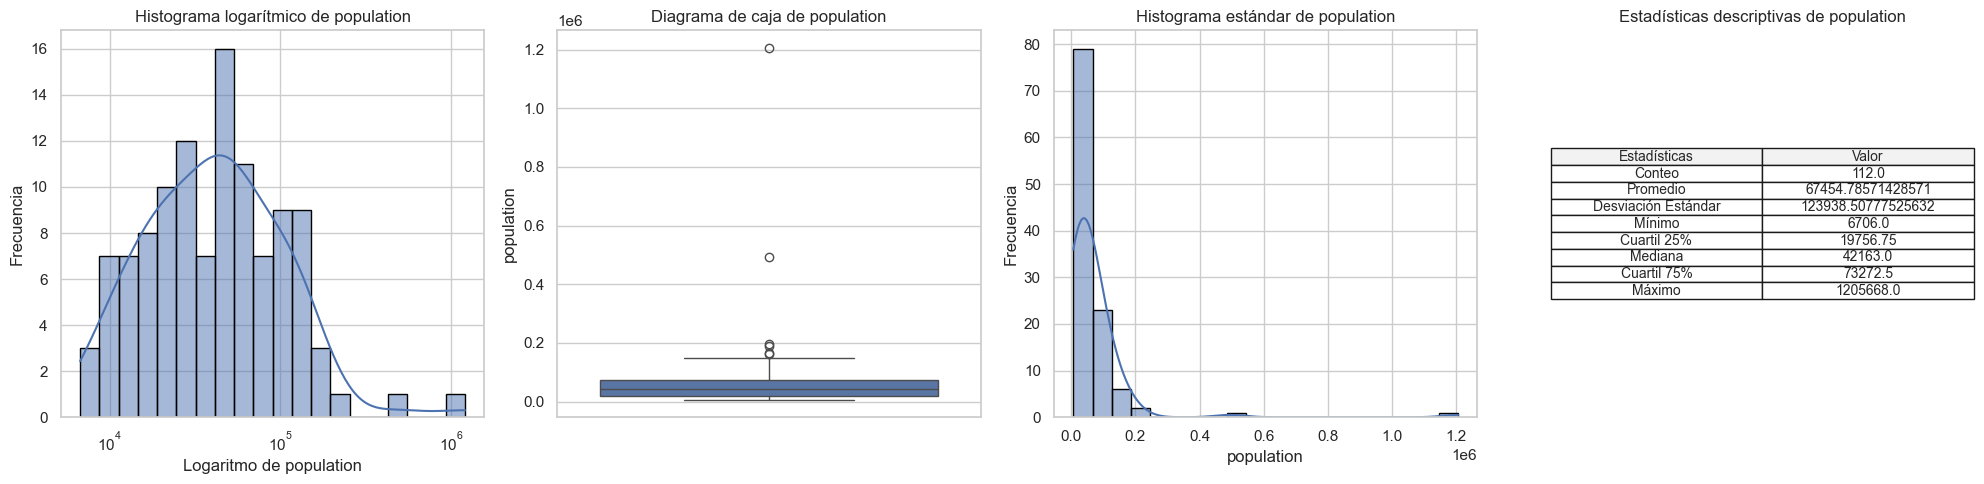

In [23]:
plot_analysis(df_municipality, 'population')

**Análisis de la variable `new_deaths`**

| **Histograma logarítmico de `new_deaths`** | **Diagrama de caja de `new_deaths`** | **Histograma estándar de `new_deaths`** |
| ------------------ | ------------------ | ----------------- |
| El histograma logarítmico muestra la distribución de nuevos casos de muerte diarios. La mayoría de los días registran una baja cantidad de nuevas muertes, pero hay algunos días con valores atípicos más altos. | El diagrama de caja presenta la variabilidad en el número de nuevas muertes diarias. La mayoría de los días tienen pocos casos, pero hay algunos días con valores atípicos más altos. | El histograma estándar muestra la distribución de nuevos casos de muerte diarios sin la transformación logarítmica. La mayoría de los días tienen pocas nuevas muertes, mientras que algunos días tienen valores excepcionalmente altos. |

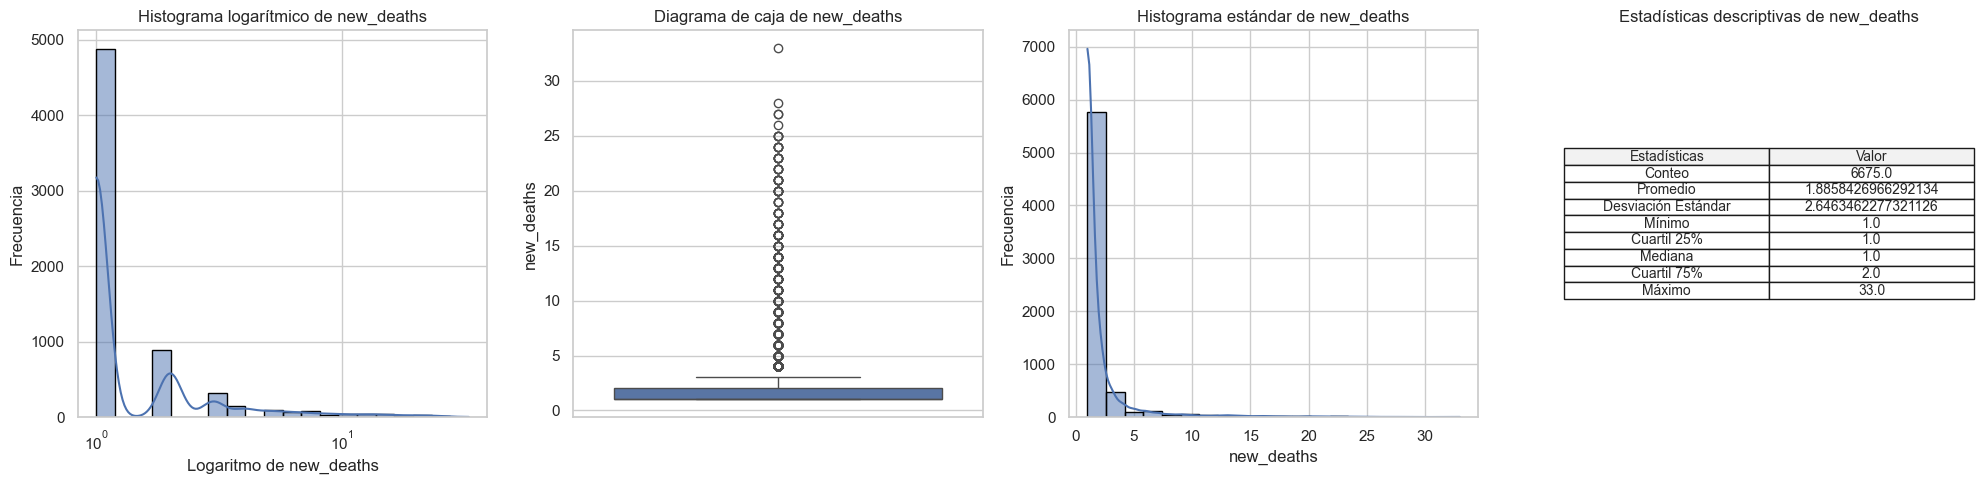

In [24]:
plot_analysis(df_mdp, 'new_deaths')

**Análisis de la variable `cumulative_deaths`**
| **Histograma logarítmico de `cumulative_deaths`** | **Diagrama de caja de `cumulative_deaths`** | **Histograma estándar de `cumulative_deaths`** |
| ------------------ | ------------------ | ------------- |
| El histograma logarítmico muestra la distribución de muertes acumulativas en los municipios. La transformación logarítmica se aplicó para mejorar la visualización. | El diagrama de caja presenta la variabilidad en el número acumulado de muertes en los municipios. Se observa una amplia gama de valores acumulativos, con algunos municipios que tienen valores atípicos significativamente más altos. | El histograma estándar muestra la distribución de muertes acumulativas en los municipios sin la transformación logarítmica. Algunos municipios tienen números acumulativos significativamente más altos que otros. |

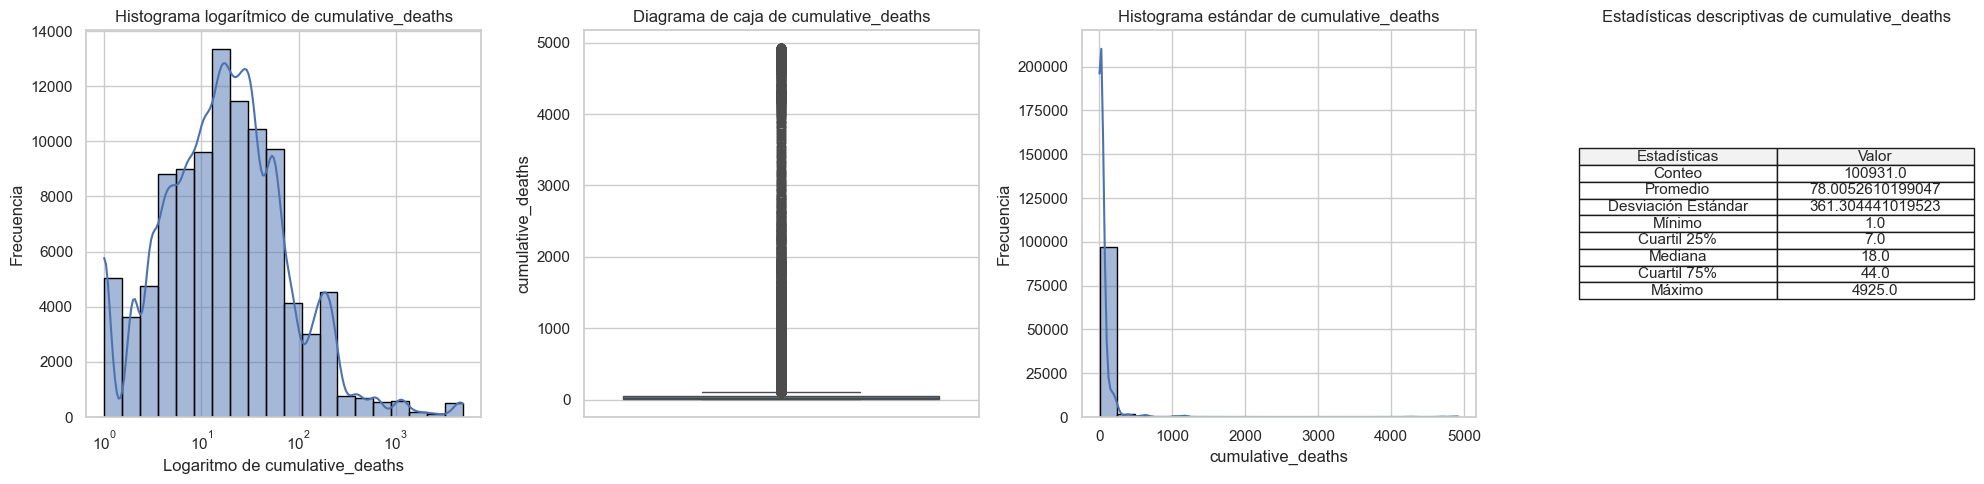

In [25]:
plot_analysis(df_mdp, 'cumulative_deaths')

### Datos Cualitativos

#### Uso y calculo de registros por departamento y municipio

<table style="border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;border-style:solid;border-width:1px" class="tg"><thead><tr><th style="background-color:#34696D;border-color:inherit;border-style:solid;border-width:0px;color:#FFF;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal" colspan="2">Cantidad total de datos de Registros de Municipios: 112</th><th style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></th><th style="background-color:#34696d;border-color:#000000;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal" colspan="2">Cantidad total de datos de Registros de Departamentos: 17</th></tr></thead><tbody><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">Municipality</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">Count</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">name_department</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">Count</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">MAZATENANGO</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">GUATEMALA</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">CUYOTENANGO</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">JALAPA</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">ACATENANGO</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">TOTONICAPAN</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">PATZICIA</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">SOLOLA</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">POCHUTA</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">ESCUINTLA</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">...</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">...</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">...</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">...</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">JOYABAJ</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">PETEN</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">CUNEN</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">QUICHE</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">PATZITE</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">HUEHUETENANGO</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">CHICHICASTENANGO</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">RETALHULEU</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">GENOVA</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">QUETZALTENANGO</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">TOTAL</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">112</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">TOTAL</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">17</td></tr></tbody></table>

**Observaciones:**
- En el análisis de Registros de Municipios se observa un total de 112 municipios distintos.
- En el análisis de Registros de Departamentos, se identifican 17 departamentos diferentes.

Ambas gráficas son similares, puesto que solo existe un registro para cada departamento y cada municipio


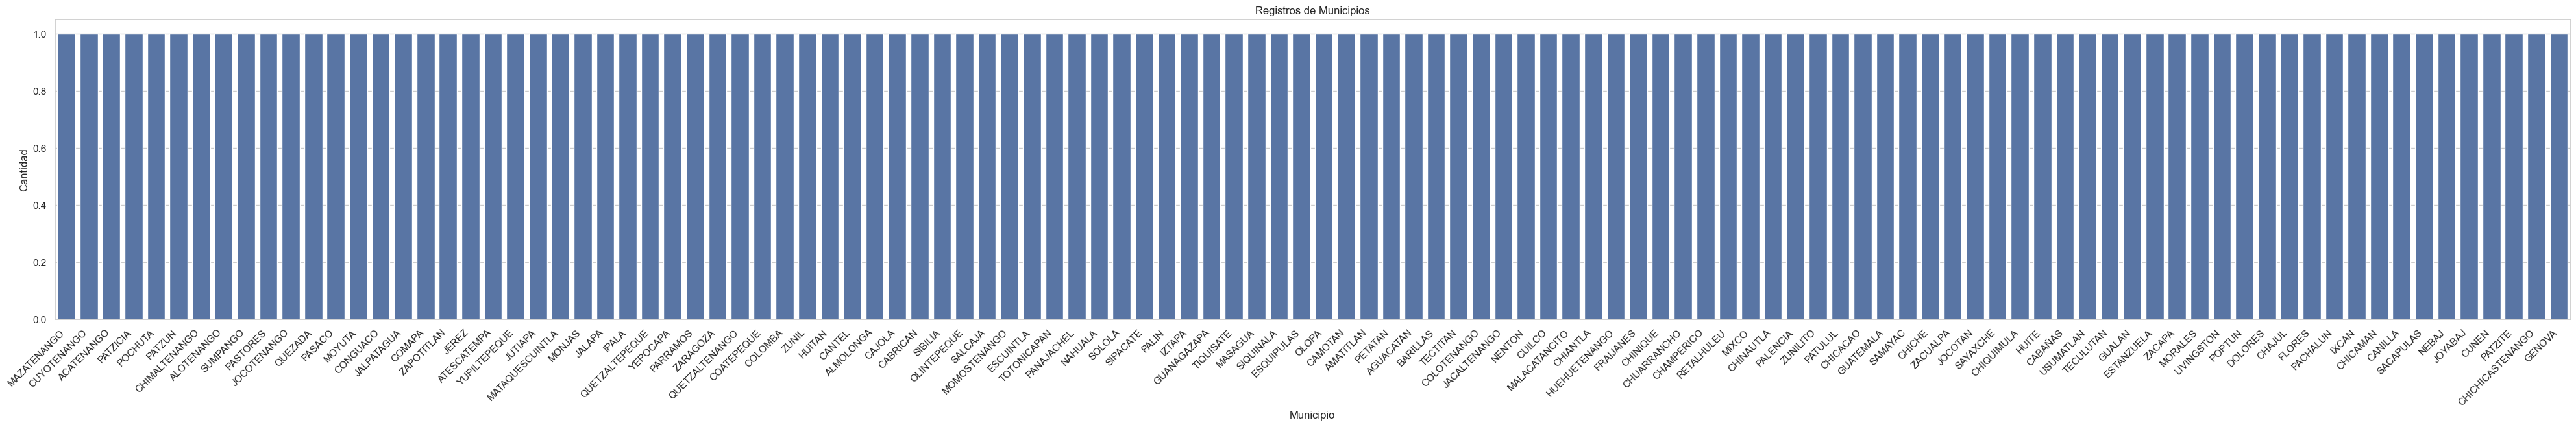

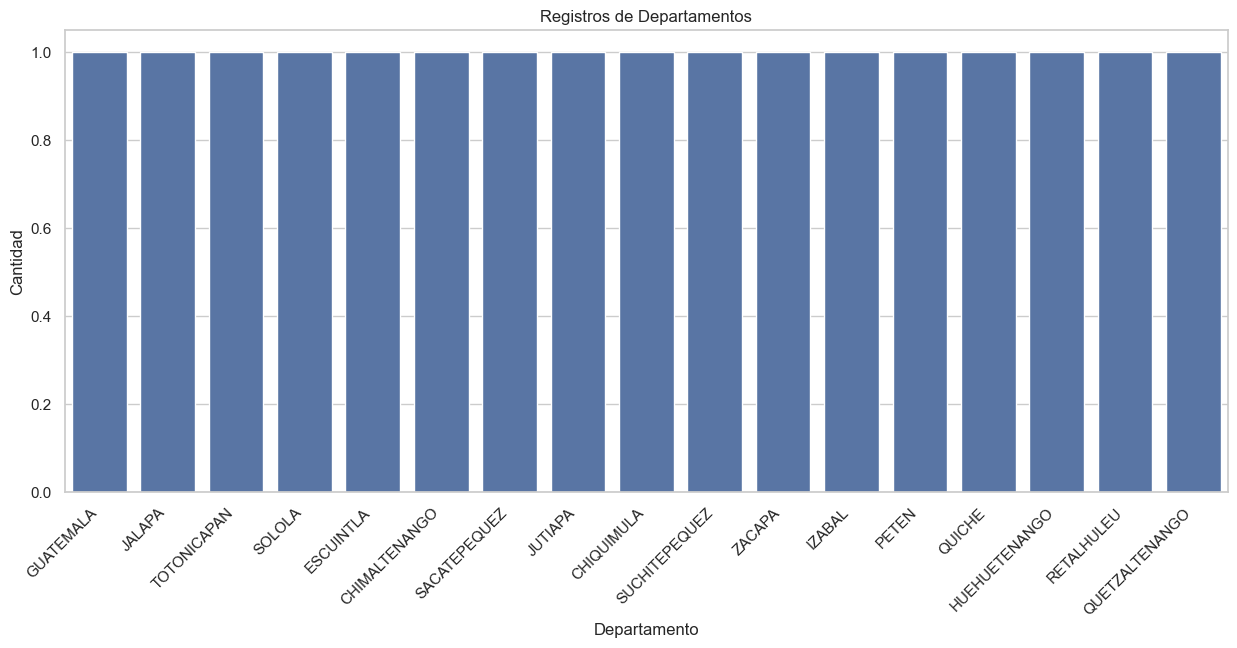

In [26]:
# Generar diagrama de barras para municipios: cantidad de veces que aparecen en los casos de covid
generate_count_plot(df_municipality, 'municipality', 'Municipio', 'Cantidad', 'Registros de Municipios', True)

# Generar diagrama de barras para municipios: cantidad de veces que aparecen en los casos de covid
generate_count_plot(df_department, 'name_department', 'Departamento', 'Cantidad', 'Registros de Departamentos')

## EDA Multivariable

### Datos cuantitativos

### Datos cualitativos

<table style="border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;border-style:solid;border-width:1px" class="tg"><thead><tr><th style="background-color:#6665cd;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#FFF;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal" colspan="2">Cantidad total de datos de Conteo de Registros de Municipios por Departamento: 112</th><th style="background-color:#ffffff;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></th><th style="background-color:#6665cd;border-color:inherit;border-style:solid;border-width:0px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal" colspan="2">Cantidad total de datos de Conteo de Registros de Muertes por Departamento</th><th style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></th><th style="background-color:#6665cd;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal" colspan="2">Cantidad total de datos de Conteo de Registros de Muertes por Municipio: 6675</th></tr></thead><tbody><tr><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">name_department</td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">Count</td><td style="background-color:#ffffff;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">name_department</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">Count</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">Municipality</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">Count</td></tr><tr><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">QUICHE</td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">14</td><td style="background-color:#ffffff;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">GUATEMALA</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1825</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">GUATEMALA</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">824</td></tr><tr><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">QUETZALTENANGO</td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">13</td><td style="background-color:#ffffff;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">QUETZALTENANGO</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">826</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">MIXCO</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">554</td></tr><tr><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">HUEHUETENANGO</td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">11</td><td style="background-color:#ffffff;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">ESCUINTLA</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">531</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">QUETZALTENANGO</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">388</td></tr><tr><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">JUTIAPA</td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">11</td><td style="background-color:#ffffff;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">HUEHUETENANGO</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">416</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">ESCUINTLA</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">265</td></tr><tr><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">ESCUINTLA</td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">8</td><td style="background-color:#ffffff;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">CHIMALTENANGO</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">352</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">COATEPEQUE</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">192</td></tr><tr><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">...</td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">...</td><td style="background-color:#ffffff;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">...</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">...</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">...</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">...</td></tr><tr><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">JALAPA</td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">3</td><td style="background-color:#ffffff;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">IZABAL</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">178</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">PASACO</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">4</td></tr><tr><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">SOLOLA</td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">3</td><td style="background-color:#ffffff;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">SOLOLA</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">178</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">OLOPA</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">4</td></tr><tr><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">IZABAL</td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">2</td><td style="background-color:#ffffff;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">SACATEPEQUEZ</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">162</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">ZAPOTITLAN</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">3</td></tr><tr><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">RETALHULEU</td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">2</td><td style="background-color:#ffffff;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">JALAPA</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">156</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">PATZITE</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">3</td></tr><tr><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">TOTONICAPAN</td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">2</td><td style="background-color:#ffffff;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">RETALHULEU</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">140</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">PETATAN</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">3</td></tr><tr><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">TOTAL</td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">112</td><td style="background-color:#ffffff;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">TOTAL</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">6675</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">TOTAL</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">6675</td></tr></tbody></table>

**Observaciones:**
En el Análisis de Registros de Municipios por Departamento, QUICHE tiene la mayor frecuencia con 14 registros, seguido por QUETZALTENANGO con 13. Y los cinco departamentos con mayor frecuencia son:
- 1. QUICHE: 14 registros
- 2. QUETZALTENANGO: 13 registros
- 3. HUEHUETENANGO: 11 registros
- 4. JUTIAPA: 11 registros
- 5. ESCUINTLA: 8 registros

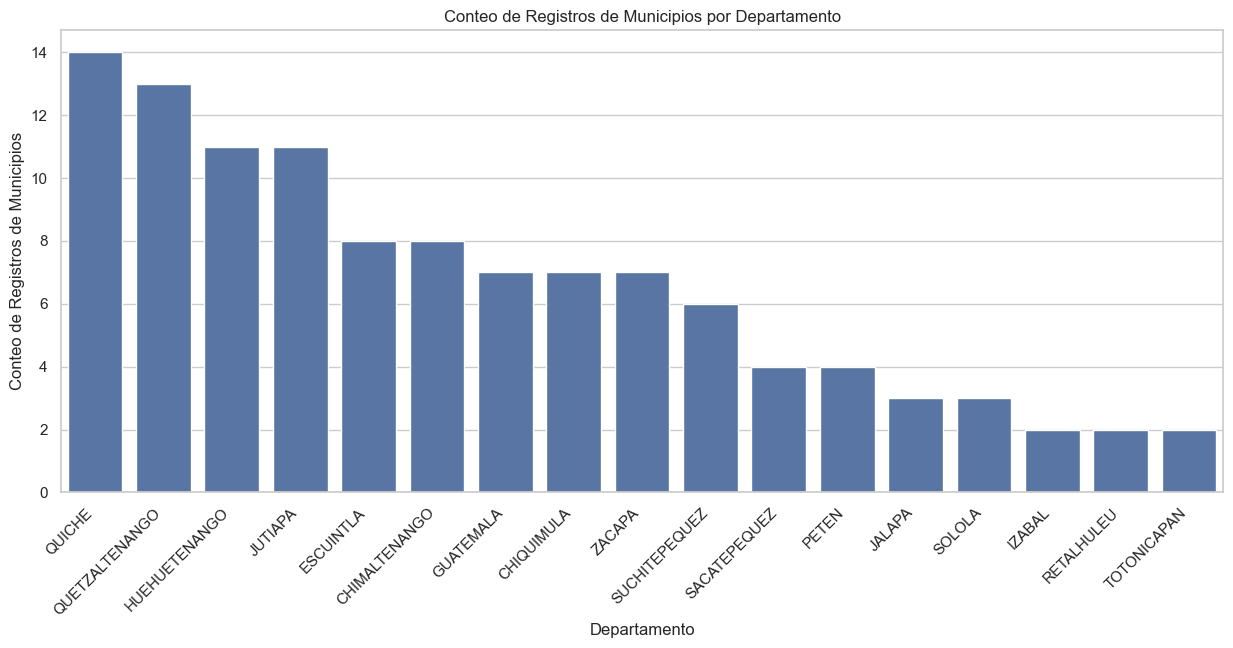

d:\Projects\SS2_Proyecto_Fase_1\Fase_2\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


TypeError: Image data of dtype object cannot be converted to float

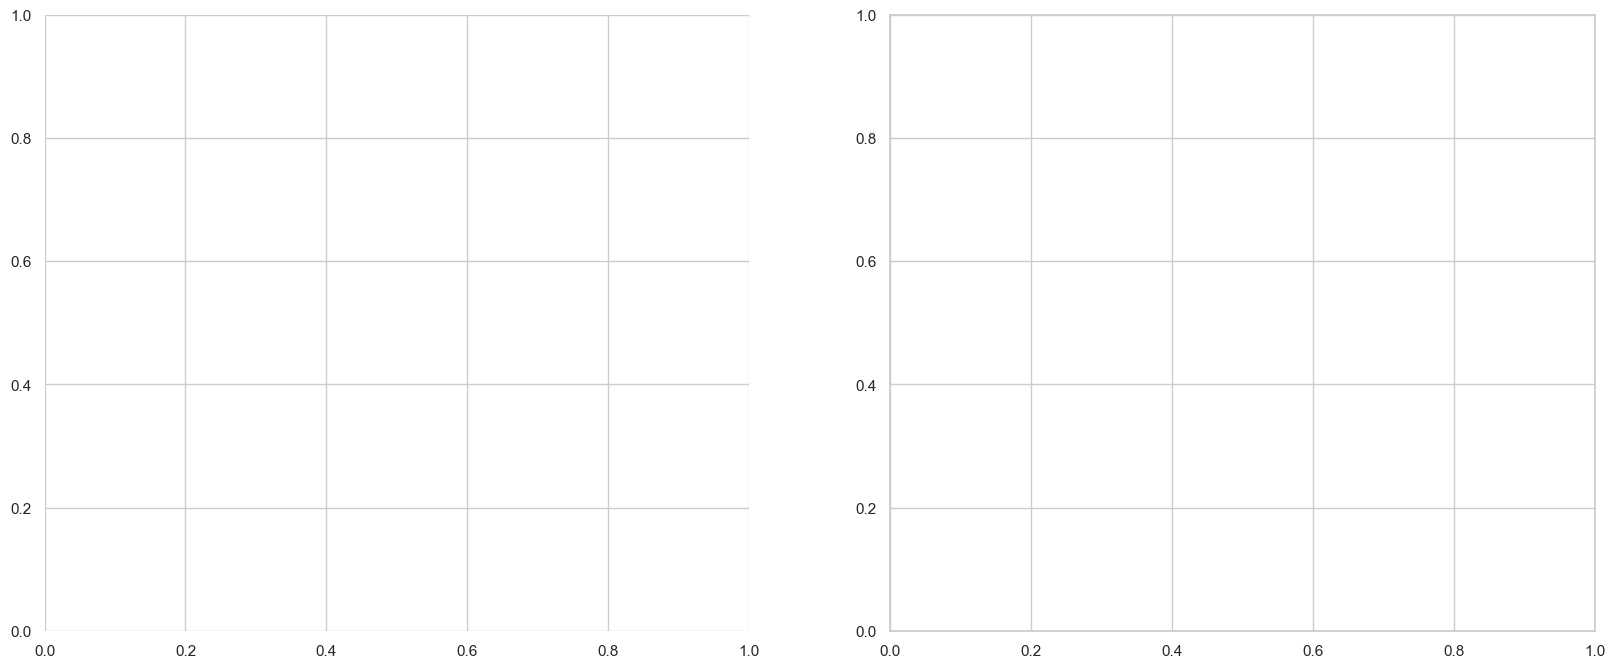

In [46]:
# Generar diagrama de barras para departamentos: cantidad de veces que aparecen en los casos de Covid
generate_count_plot(df_municipality, 'name_department', 'Departamento', 'Conteo de Registros de Municipios', 'Conteo de Registros de Municipios por Departamento')
# generate_heatmaps(df_municipality, 'code_municipality', 'name_department', 'Departamento', 'Cantidad de Nuevas Muertes', 'Departamentos vs cantidad de nuevas muertes', 10, 8, 2)

El Análisis de Muertes por Municipio muestra un total de 6,675 registros. El municipio más frecuente es GUATEMALA con 824 casos. Los cinco municipios más frecuentes son:
- 1. GUATEMALA: 824 casos
- 2. MIXCO: 554 casos
- 3. QUETZALTENANGO: 388 casos
- 4. ESCUINTLA: 265 casos
- 5. COATEPEQUE: 192 casos

Además, se puede apreciar por la gráfica del mapa de calor qué municipios tienen una cantidad de casos mayor.

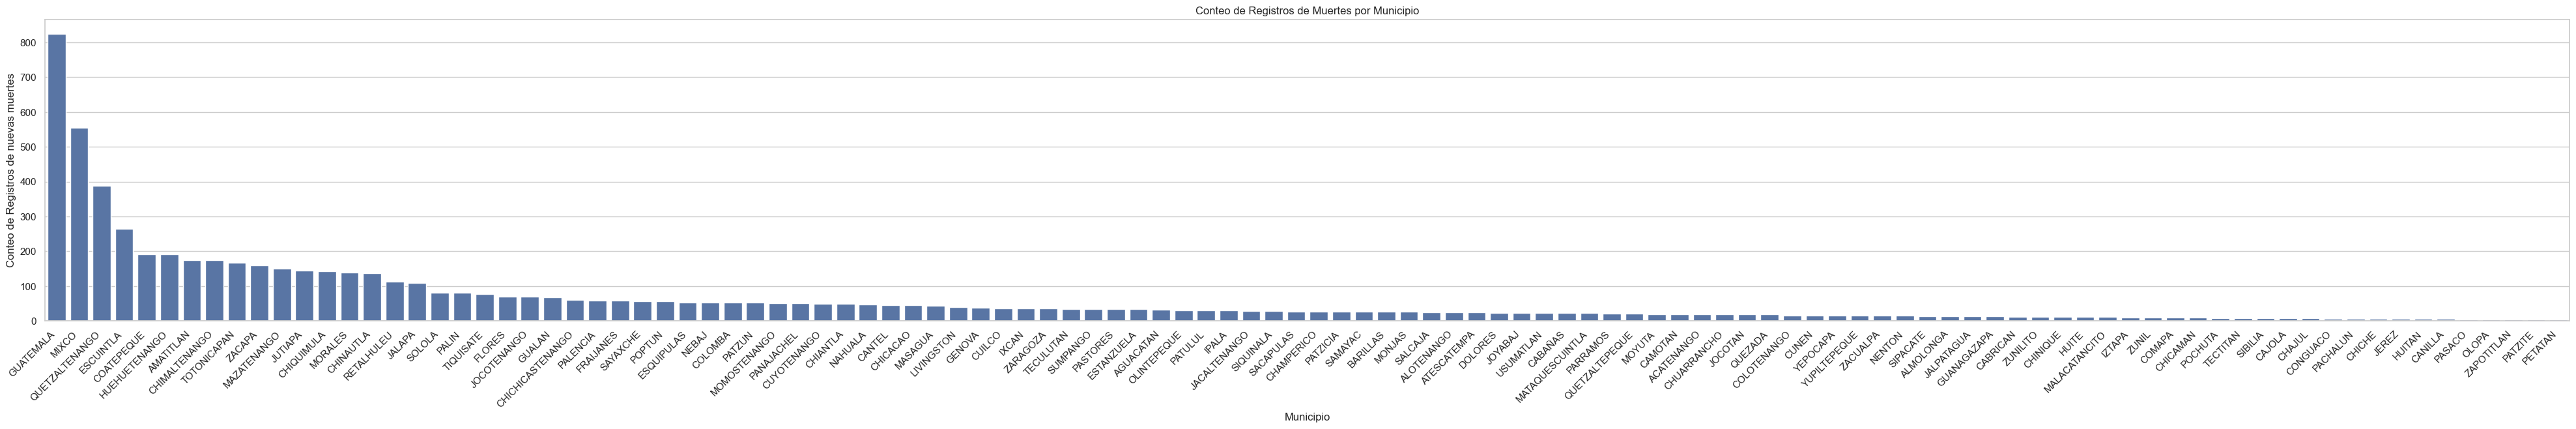

d:\Projects\SS2_Proyecto_Fase_1\Fase_2\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


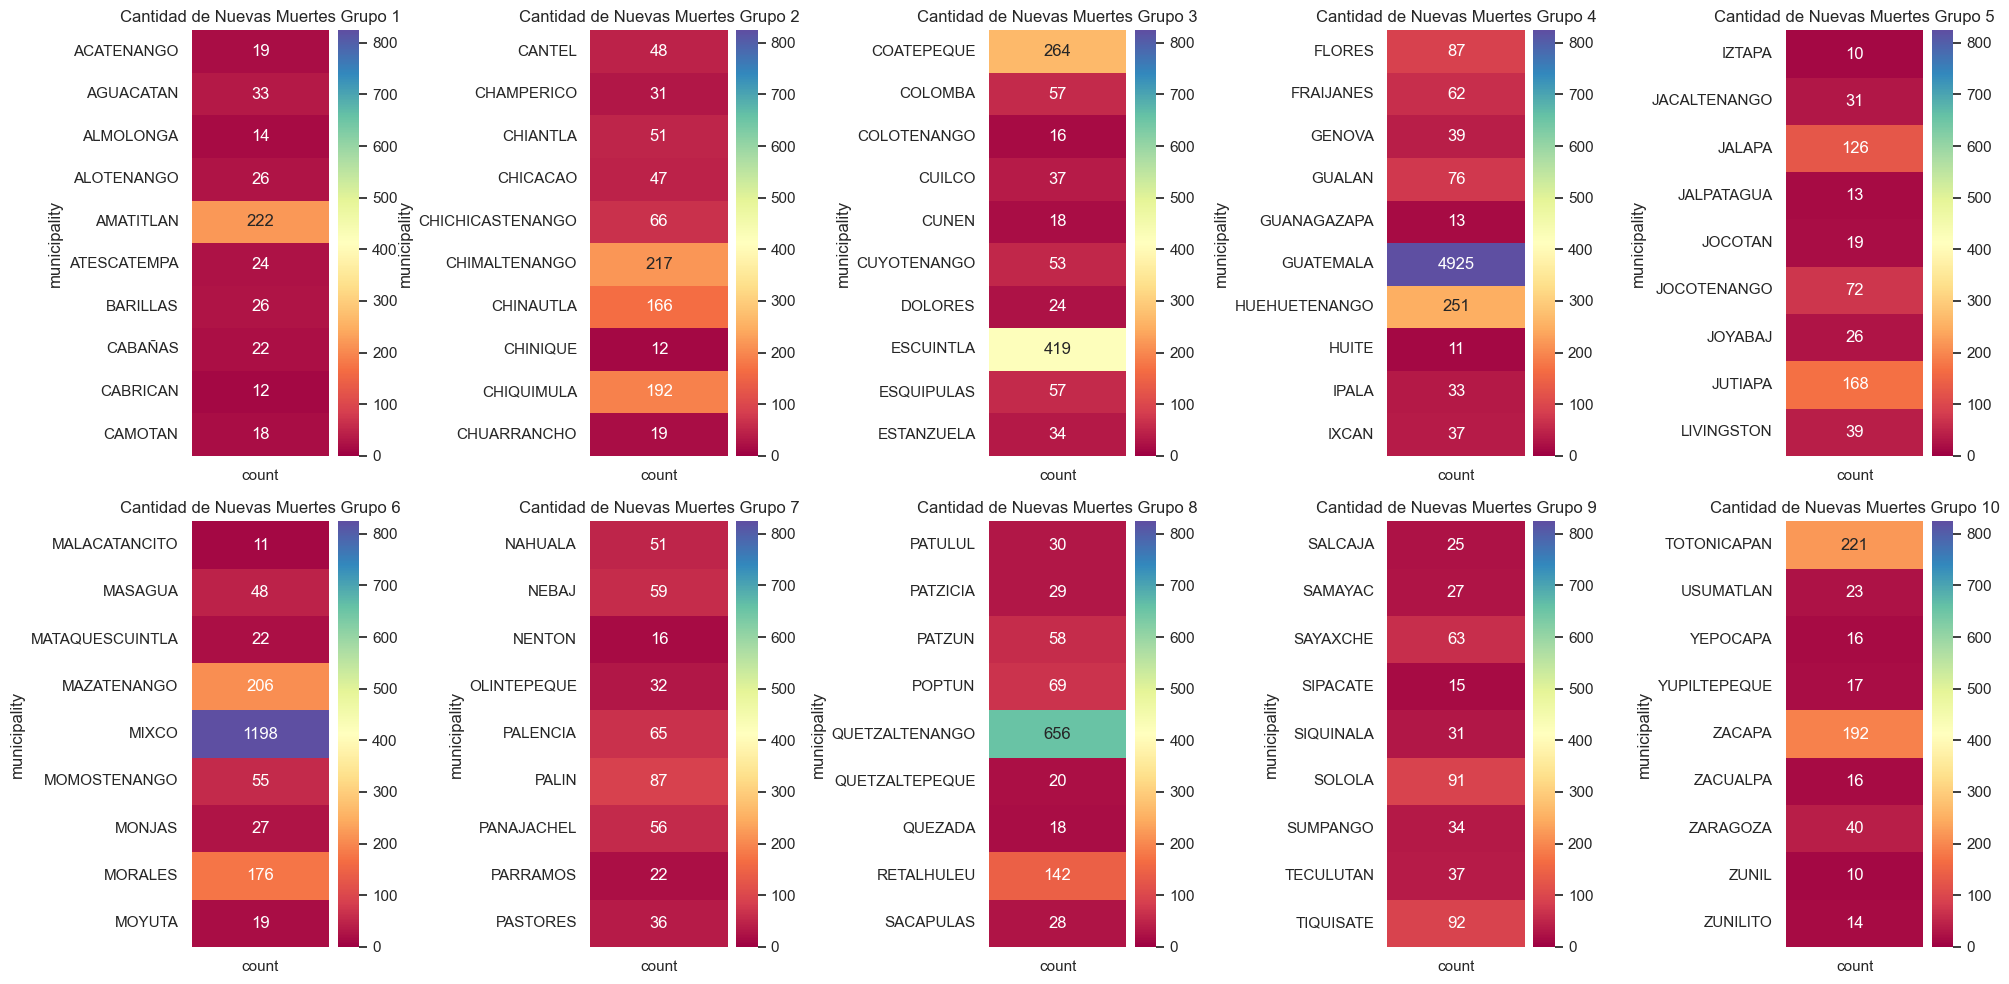

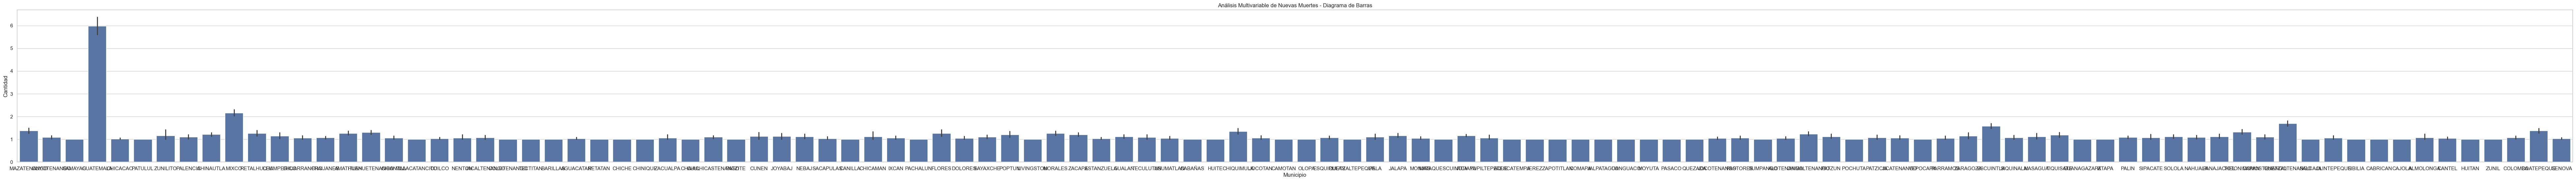

In [28]:
# Generar diagrama de barras para municipios: cantidad de veces que aparecen en los casos de covid
generate_count_plot(df_mdp_gt_0, 'municipality', 'Municipio', 'Conteo de Registros de nuevas muertes', 'Conteo de Registros de Muertes por Municipio', True)
generate_heatmaps(df_mdp_gt_0, 'new_deaths', 'municipality', 'Municipio', 'Cantidad de Nuevas Muertes', 'Municipios vs cantidad de nuevas muertes', 10, 10, 5)
generate_multivariable_plots(df_mdp_gt_0, 'municipality', 'new_deaths', 'cumulative_deaths', 'Municipio', 'Cantidad', 'Análisis Multivariable de Nuevas Muertes')

El Análisis de Muertes por Departamento muestra un total de 6,675 registros. El Departamento más frecuente es GUATEMALA con 824 casos. Y los departamentos con mayor frecuencia y su respectivo conteo son:
- 1. GUATEMALA: 1,825 registros
- 2. QUETZALTENANGO: 826 registros
- 3. ESCUINTLA: 531 registros
- 4. HUEHUETENANGO: 416 registros
- 5. CHIMALTENANGO: 352 registros

Además, se puede apreciar por la gráfica del mapa de calor qué Departamentos tienen una cantidad de casos mayor.

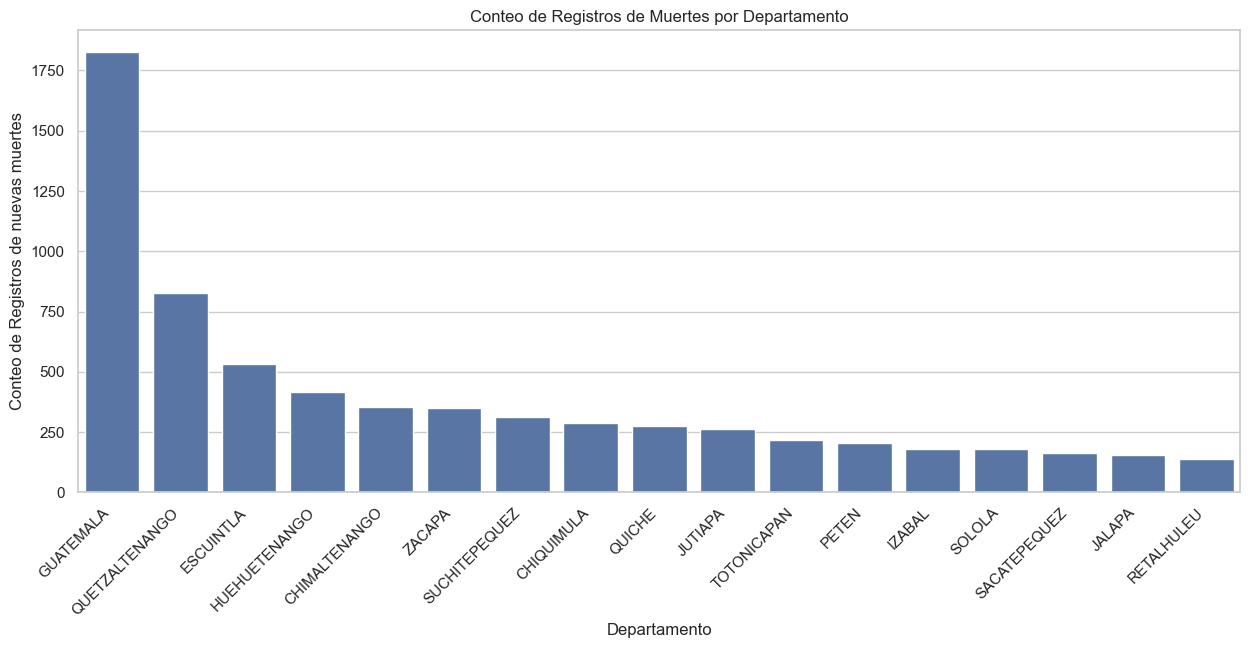

d:\Projects\SS2_Proyecto_Fase_1\Fase_2\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


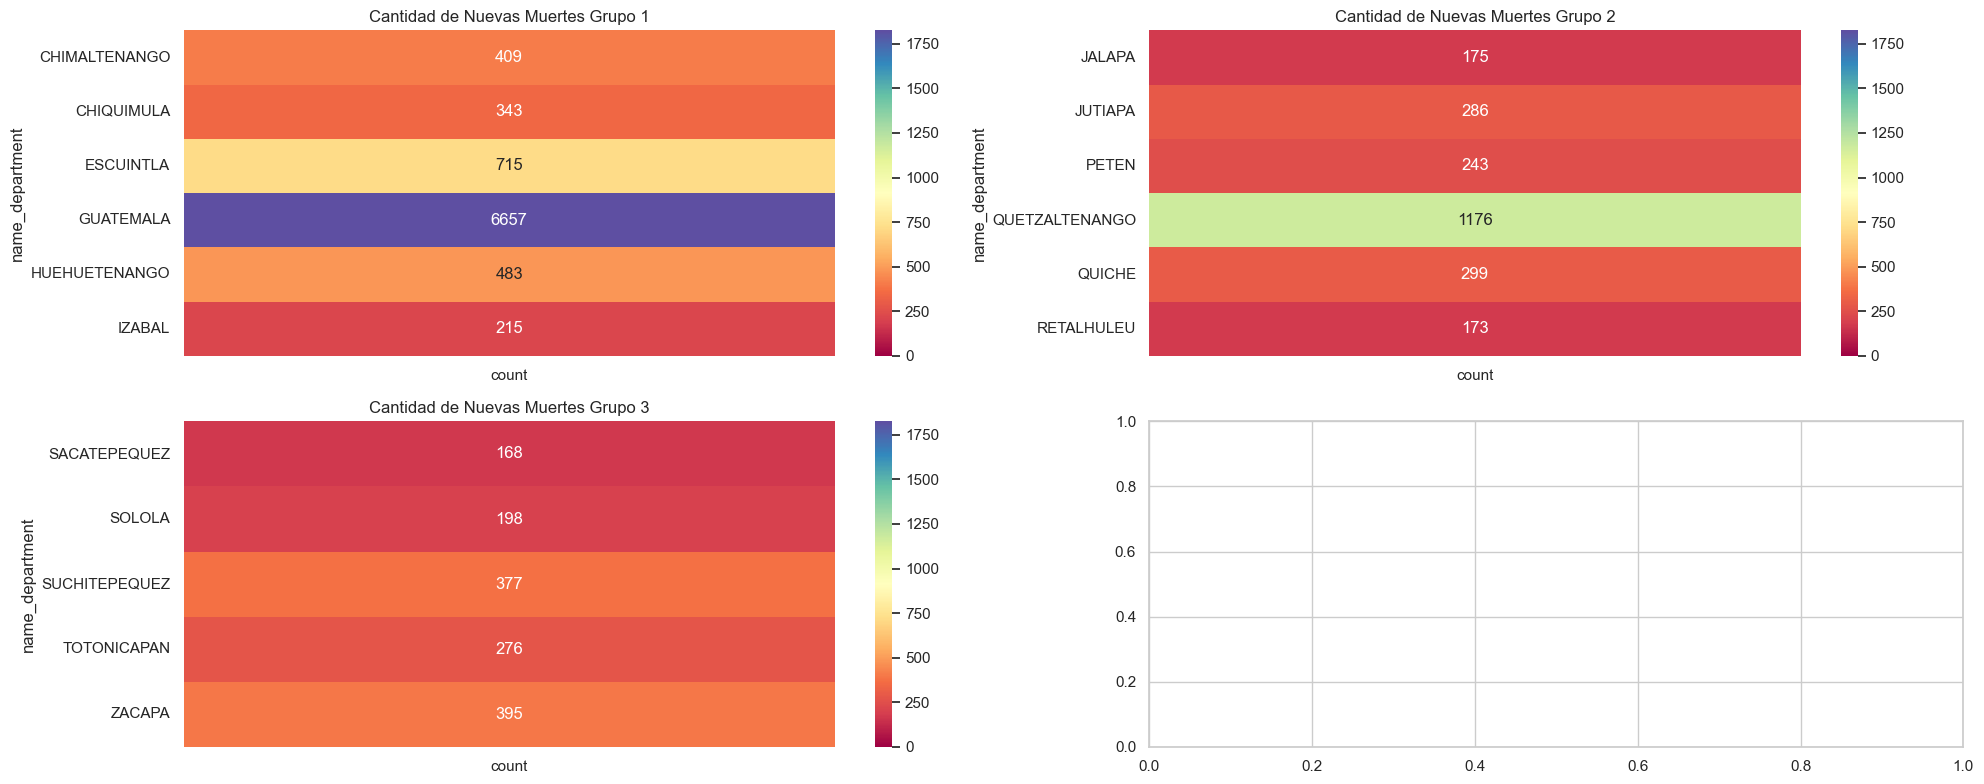

In [29]:
# Generar diagrama de barras para departamentos: cantidad de veces que aparecen en los casos de covid
generate_count_plot(df_mdp_gt_0, 'name_department', 'Departamento', 'Conteo de Registros de nuevas muertes', 'Conteo de Registros de Muertes por Departamento')
generate_heatmaps(df_mdp_gt_0, 'new_deaths', 'name_department', 'Departamento', 'Cantidad de Nuevas Muertes', 'Departamentos vs cantidad de nuevas muertes', 10, 8, 2)

Para el análisis de **Conteo de Registros de Muertes Acumuladas por Municipio:**

El Análisis de Muertes por Municipio muestra un total de 6,675 registros.
El Municipio más frecuente es GUATEMALA con 824 casos.
Y los municipios con mayor frecuencia y su respectivo conteo son:
- 1. GUATEMALA: 4925 Muertes acumuladas.
- 2. MIXCO: 1198 Muertes acumuladas.
- 3. QUETZALTENANGO: 656 Muertes acumuladas.

Además, se puede apreciar por la gráfica del mapa de calor qué municipios tienen una cantidad de muertes acumuladas mayor.

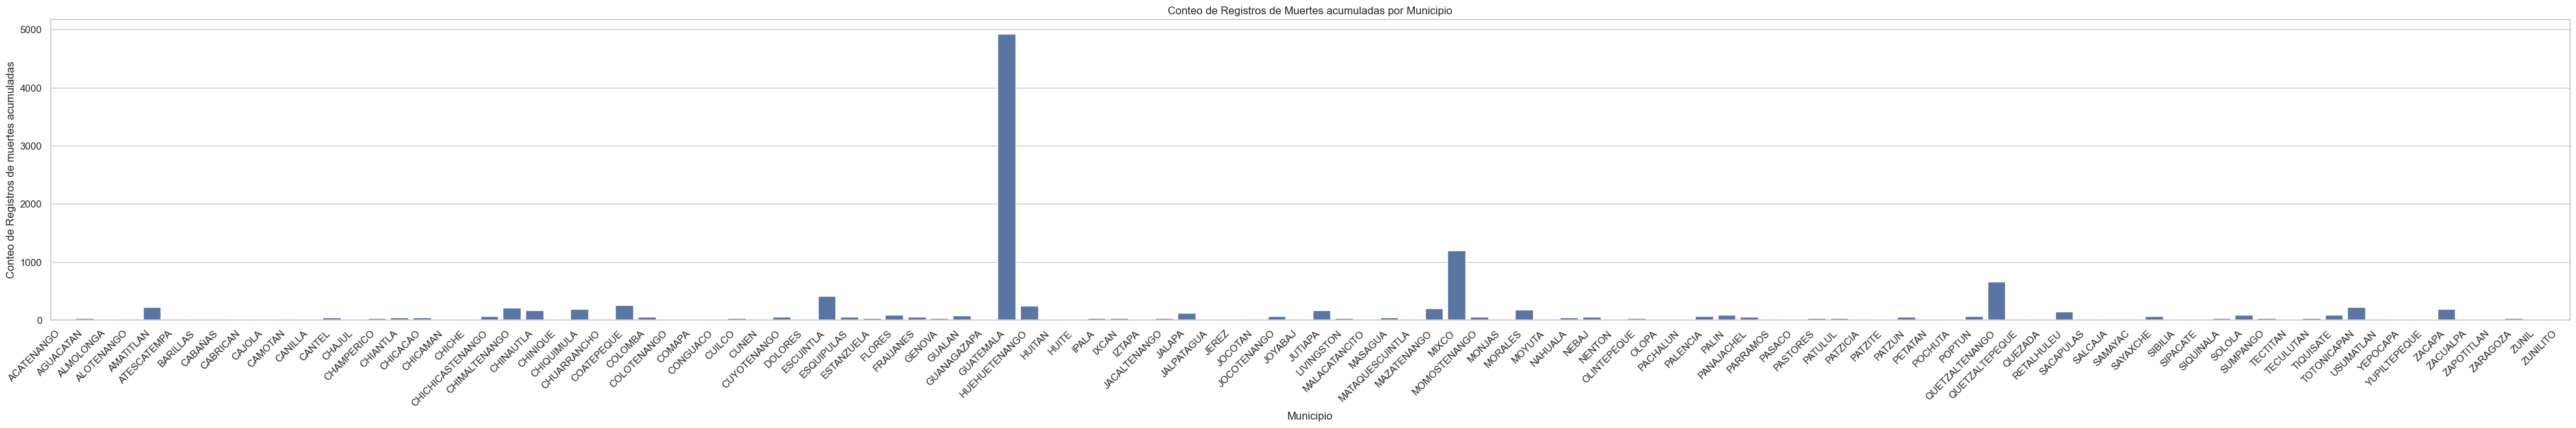

d:\Projects\SS2_Proyecto_Fase_1\Fase_2\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


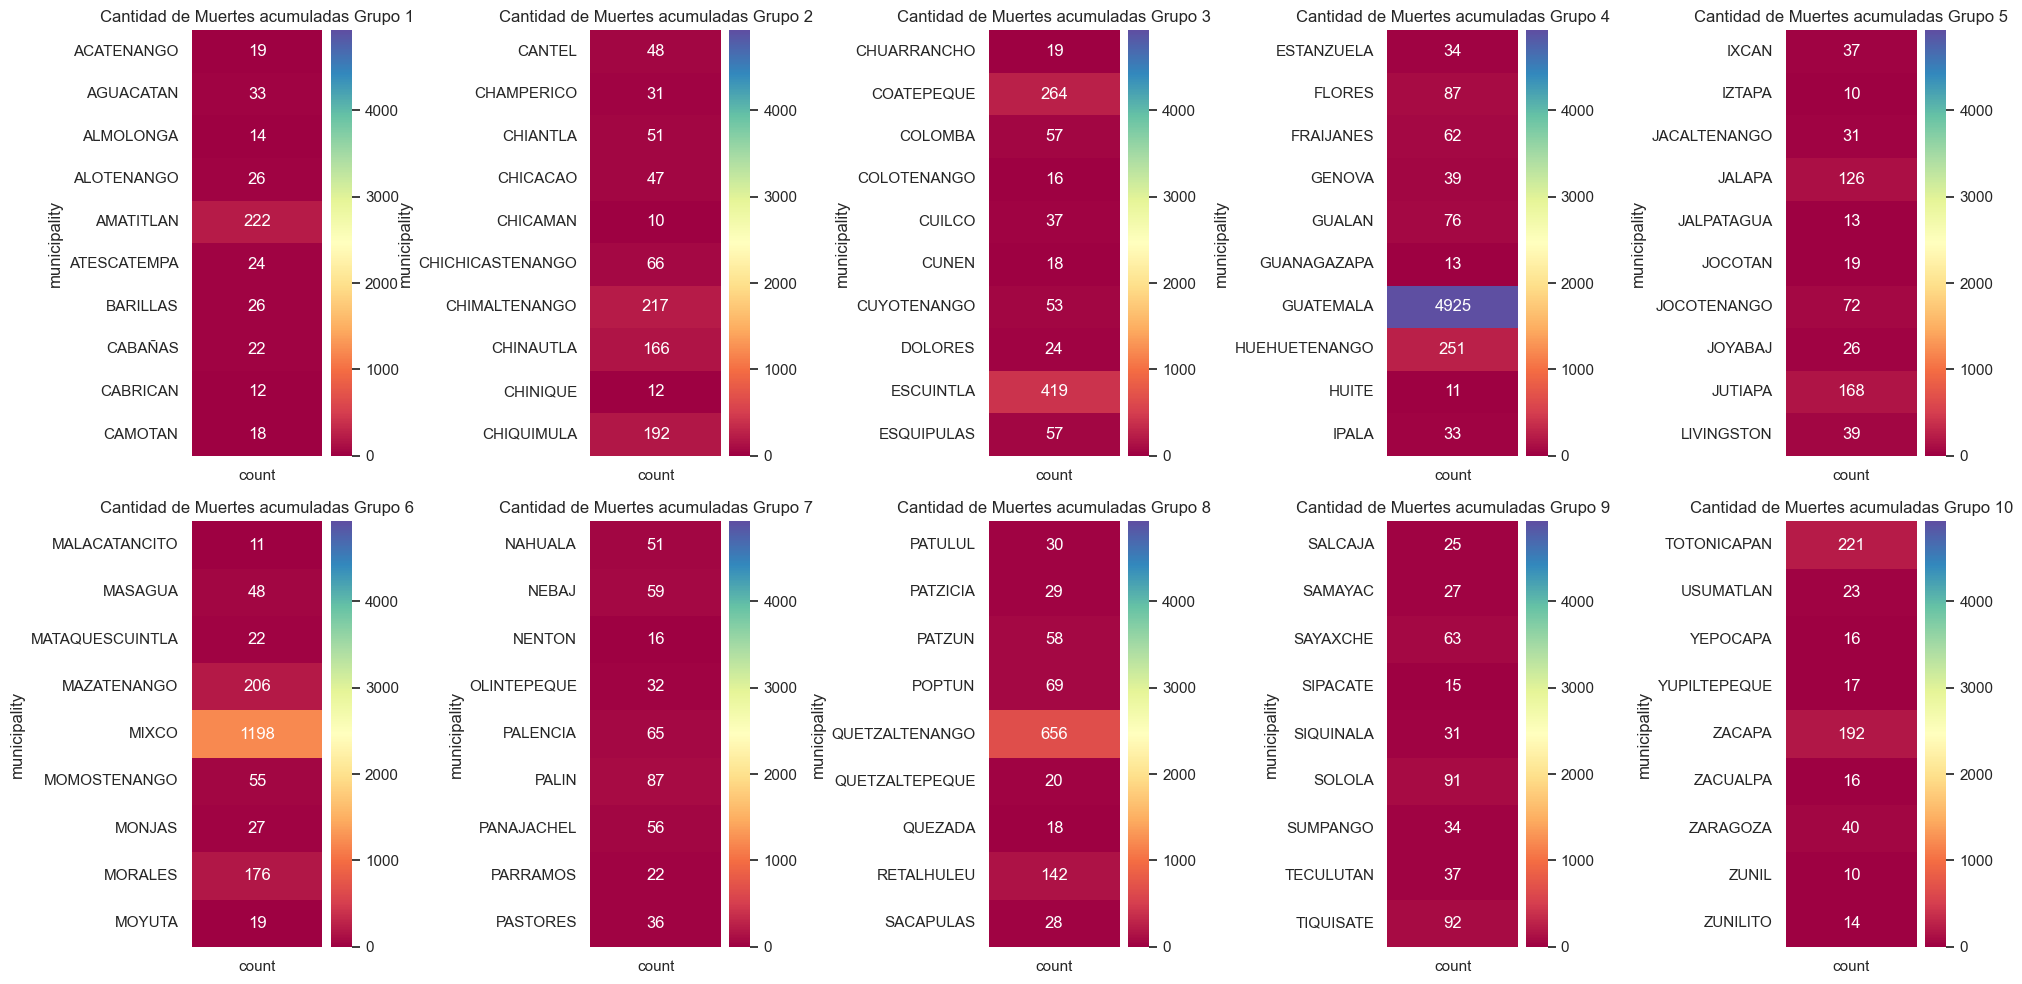

In [30]:
# Generar diagrama de barras para municipios: cantidad de veces que aparecen en los casos de covid
generate_sum_plot(df_mdp_gt_0, 'new_deaths','municipality', 'Municipio', 'Conteo de Registros de muertes acumuladas', 'Conteo de Registros de Muertes acumuladas por Municipio', True)
generate_heatmaps(df_mdp_gt_0, 'new_deaths', 'municipality', 'Municipio', 'Cantidad de Muertes acumuladas', 'Municipios vs cantidad de muertes acumuladas', 10, 10, 5, False)

Mis disculpas por la confusión. Aquí está el análisis similar al que proporcionaste:

Para el análisis de **Conteo de Muertes Acumuladas por Departamento:**

El Análisis de Muertes por Departamento muestra un total de 6,675 registros.
El Departamento más frecuente es GUATEMALA con 6656 casos.
Y los departamentos con mayor frecuencia y su respectivo conteo son:
- 1. GUATEMALA: 6,656 Muertes acumuladas
- 2. QUETZALTENANGO: 1176 Muertes acumuladas
- 3. ESCUINTLA: 715 Muertes acumuladas

Además, se puede apreciar por la gráfica del mapa de calor qué Departamentos tienen una cantidad de muertes mayor.

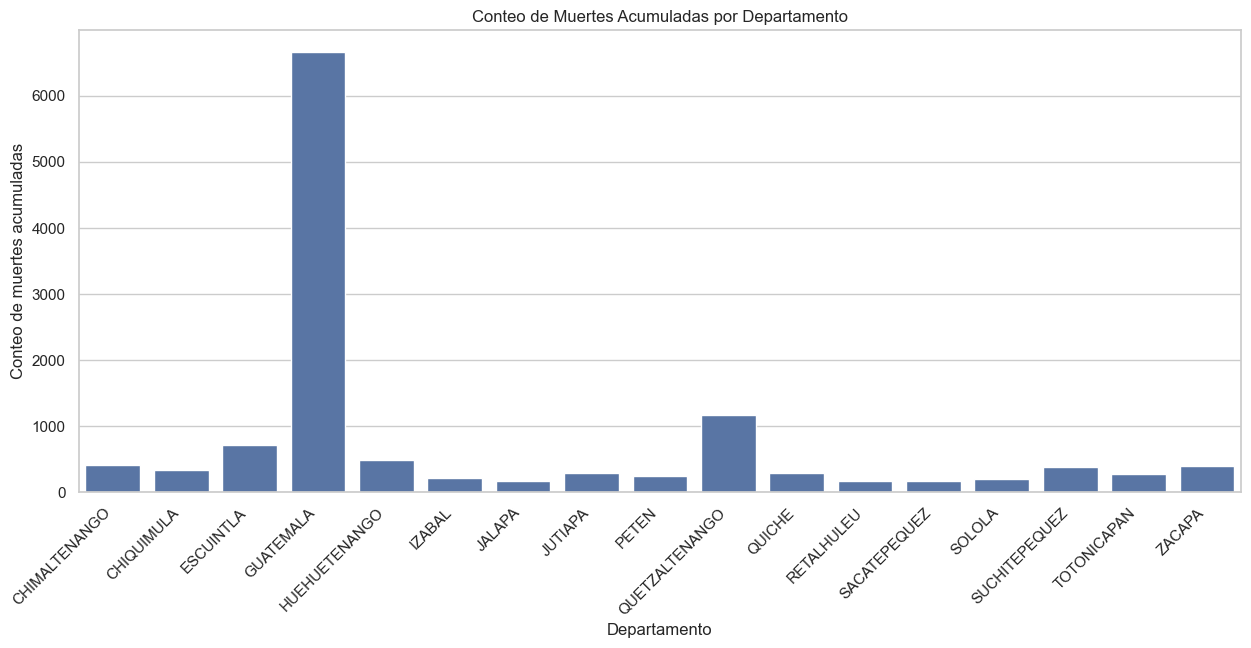

d:\Projects\SS2_Proyecto_Fase_1\Fase_2\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


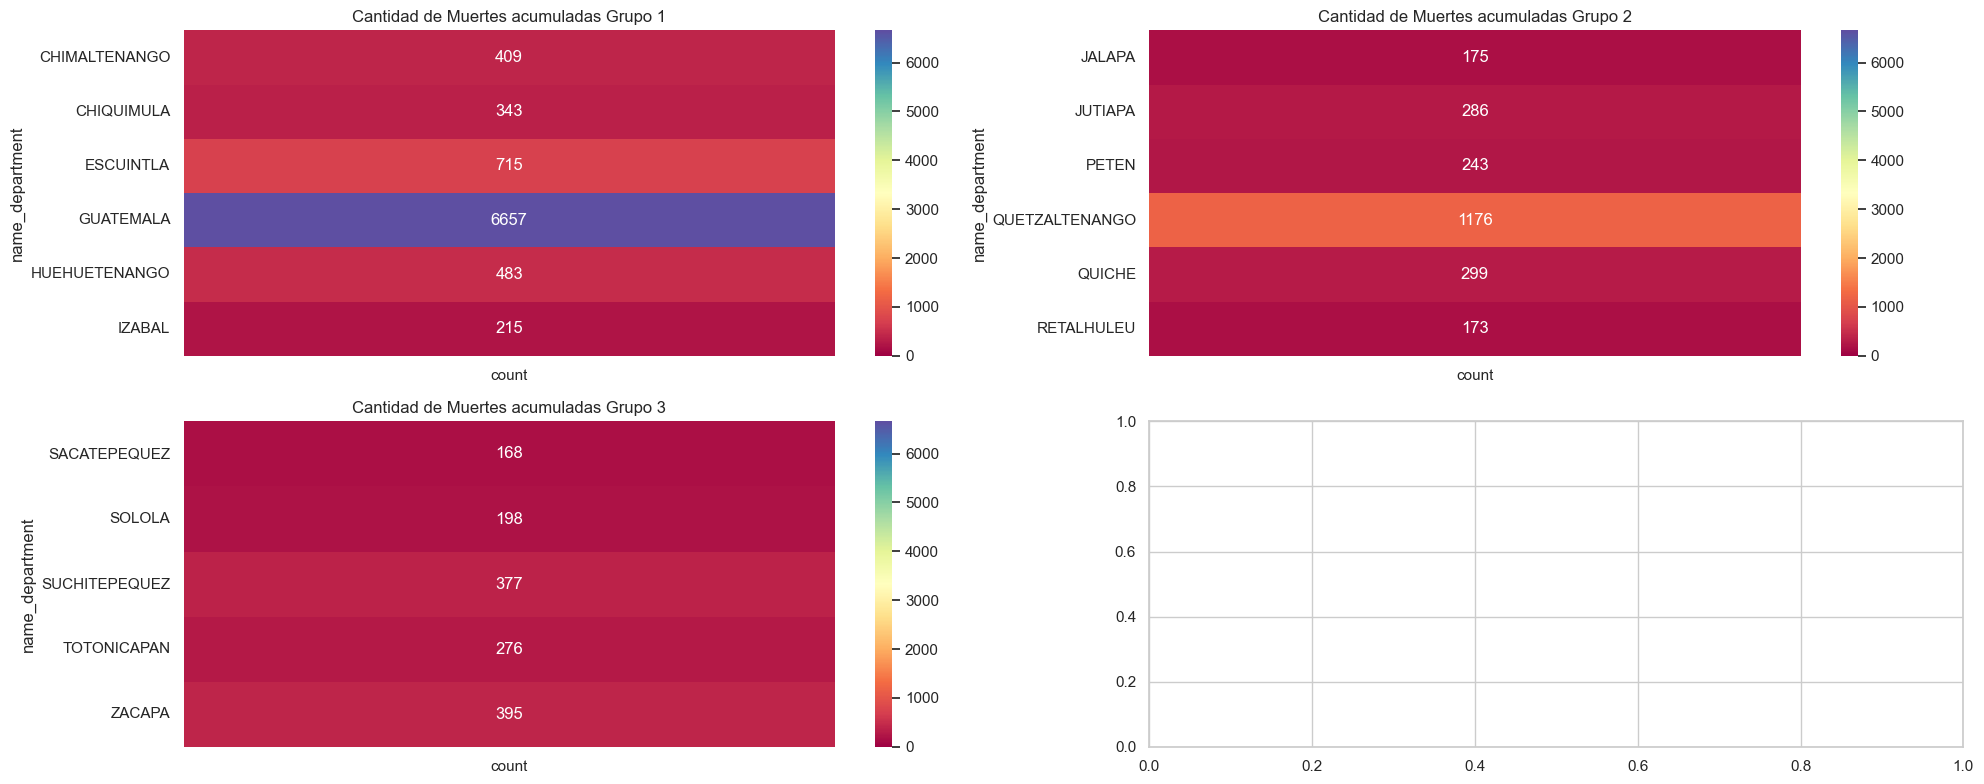

In [31]:
# Generar diagrama de barras para departamentos: cantidad de veces que aparecen en los casos de covid
generate_sum_plot(df_mdp_gt_0, 'new_deaths','name_department', 'Departamento', 'Conteo de muertes acumuladas', 'Conteo de Muertes Acumuladas por Departamento', False)
generate_heatmaps(df_mdp_gt_0, 'new_deaths', 'name_department', 'Departamento', 'Cantidad de Muertes acumuladas', 'Departamentos vs cantidad de muertes acumuladas', 10, 8, 2, False)